In [1]:
from collections import deque

import gym
import imageio
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn

In [2]:
class DuelingDQN(nn.Module):
    def __init__(self, obs_space, action_space):
        super().__init__()

        self.head = nn.Sequential(
            nn.Linear(obs_space, 256),
            nn.SELU(),
#             nn.Linear(256, 256),
#             nn.SELU()
        )

        self.val = nn.Sequential(
            nn.Linear(256, 256),
            nn.SELU(),
            nn.Linear(256, 1)
        )

        self.adv = nn.Sequential(
            nn.Linear(256, 256),
            nn.SELU(),
            nn.Linear(256, action_space)
        )

    def forward(self, x):
        out = self.head(x)
        val_out = self.val(out).reshape(out.shape[0], 1)
        adv_out = self.adv(out).reshape(out.shape[0], -1)
        adv_mean = adv_out.mean(dim=1, keepdim=True)
        q = val_out + adv_out - adv_mean

        return q

In [3]:
def select_action(obs, tgt_net):
    tgt_net.eval()
    with torch.no_grad():
        state = torch.tensor([obs]).to(device).float()
        q = tgt_net(state)
        action = torch.argmax(q)

    return action.item()

## Main

In [4]:
# set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# make an environment
# env = gym.make('CartPole-v0')
# env = gym.make('CartPole-v1')
env = gym.make('MountainCar-v0')
# env = gym.make('LunarLander-v2')

SEED = 0
env.seed(SEED)
obs_space = env.observation_space.shape[0]
action_space = env.action_space.n

# hyperparameter
n_episodes = 1000
n_eval = env.spec.trials

# global values
total_steps = 0
rewards = []
reward_eval = deque(maxlen=n_eval)
is_solved = False

# load a model
target_net = DuelingDQN(obs_space, action_space).to(device)
target_net.load_state_dict(torch.load(
    './saved_models/MountainCar-v0_ep623_clear_model_dddqn.pt'))

/home/jay/anaconda3/lib/python3.6/site-packages/gym/__init__.py:22: UserWarning: DEPRECATION WARNING: to improve load times, gym no longer automatically loads gym.spaces. Please run "import gym.spaces" to load gym.spaces on your own. This warning will turn into an error in a future version of gym.
  warnings.warn('DEPRECATION WARNING: to improve load times, gym no longer automatically loads gym.spaces. Please run "import gym.spaces" to load gym.spaces on your own. This warning will turn into an error in a future version of gym.')


WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


In [5]:
env.spec.max_episode_steps

200

In [6]:
env.spec.trials

100

In [7]:
env.spec.reward_threshold

-110.0

In [8]:
# env.metadata['video.frames_per_second'] = 60

In [9]:
# play
# frames = []
for i in range(1, n_episodes + 1):
    obs = env.reset()
    done = False
    ep_reward = 0
    while not done:
#         frames.append(env.render(mode = 'rgb_array'))
        env.render()
        action = select_action(obs, target_net)
        _obs, reward, done, _ = env.step(action)
        obs = _obs
        total_steps += 1
        ep_reward += reward     
    if done:
        env.render()
        rewards.append(ep_reward)
        reward_eval.append(ep_reward)
        print('{:3} Episode in {:5} steps, reward {:.2f}'.format(
            i, total_steps, ep_reward))
#         frames.append(env.render(mode = 'rgb_array'))
#         imageio.mimsave(f'{env.spec.id}.gif', frames,)
        
        if len(reward_eval) >= n_eval:
            if np.mean(reward_eval) >= env.spec.reward_threshold:
                print('\n{} is sloved! {:3} Episode in {:3} steps'.format(
                    env.spec.id, i, total_steps))
                print(np.mean(reward_eval))
                break
env.close()

  1 Episode in   113 steps, reward -113.00
  2 Episode in   197 steps, reward -84.00
  3 Episode in   304 steps, reward -107.00
  4 Episode in   415 steps, reward -111.00
  5 Episode in   529 steps, reward -114.00
  6 Episode in   636 steps, reward -107.00
  7 Episode in   745 steps, reward -109.00
  8 Episode in   852 steps, reward -107.00
  9 Episode in   965 steps, reward -113.00
 10 Episode in  1073 steps, reward -108.00
 11 Episode in  1186 steps, reward -113.00
 12 Episode in  1270 steps, reward -84.00
 13 Episode in  1379 steps, reward -109.00
 14 Episode in  1486 steps, reward -107.00
 15 Episode in  1570 steps, reward -84.00
 16 Episode in  1676 steps, reward -106.00
 17 Episode in  1785 steps, reward -109.00
 18 Episode in  1889 steps, reward -104.00
 19 Episode in  2002 steps, reward -113.00
 20 Episode in  2105 steps, reward -103.00
 21 Episode in  2211 steps, reward -106.00
 22 Episode in  2324 steps, reward -113.00
 23 Episode in  2433 steps, reward -109.00
 24 Episode in

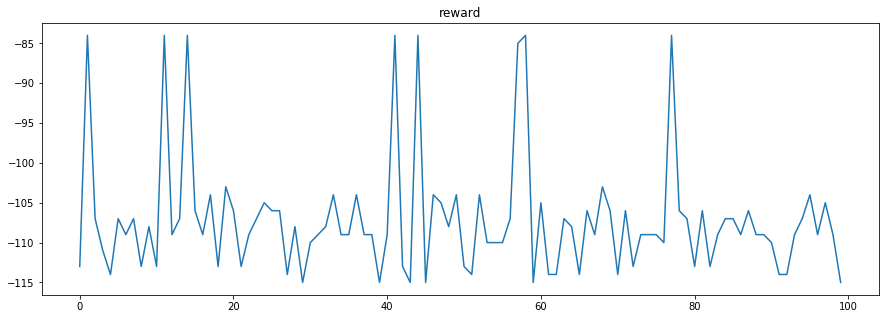

In [10]:
plt.figure(figsize=(15, 5))
plt.title('reward')
plt.plot(rewards)
plt.show()

In [11]:
[
    ('CartPole-v0', 412, 1),
    ('CartPole-v1', 452, 0.05),
    ('MountainCar-v0', 193, 0.1),
    ('LunarLander-v2', 260, 0.1)
]

[('CartPole-v0', 412, 1),
 ('CartPole-v1', 452, 0.05),
 ('MountainCar-v0', 193, 0.1),
 ('LunarLander-v2', 260, 0.1)]